<a href="https://colab.research.google.com/github/MonicaKim89/Fire_detection/blob/main/VGG16_test_20210504.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import math
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)'
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras import optimizers


IMG_SIZE = 224
NUM_EPOCHS = 20
NUM_CLASSES = 3
TRAIN_BATCH_SIZE = 77
TEST_BATCH_SIZE = 1 
opt =  tf.optimizers.Adam()


In [15]:
def create_model():
  #vgg_weights_path = '../input/vgg16/vgg16.h5'
  vgg= VGG16(include_top=False, weights=None ) 
  #vgg.summary()
  my_new_model = Sequential()
  my_new_model.add(vgg)
  my_new_model.add(GlobalAveragePooling2D())
  my_new_model.layers[0].trainable = True
  #my_new_model.layers[1].trainable = False

  my_new_model.add(Dense(NUM_CLASSES, activation='softmax')) #dense 3, NUM_CLASSES = 3

  # Say no to train first layer (ResNet) model. It is already trained
    
  opt =  tf.optimizers.Adam()
   #opt바꾼거 확인해
  my_new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return my_new_model

In [3]:
def train_model( model ):
    #ata_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

    data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                #sear_range=0.01,
                                zoom_range=[0.9, 1.25],
                                horizontal_flip=True,
                                vertical_flip=False,
                                data_format='channels_last',
                                brightness_range=[0.5, 1.5]
                               )
                                       
    train_generator = data_generator_with_aug.flow_from_directory(
            '/content/drive/MyDrive/Caba2012_colab/Fire_dt/datasets/train',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical')
    
   
    validation_generator = data_generator_with_aug.flow_from_directory(
            '/content/drive/MyDrive/Caba2012_colab/Fire_dt/datasets/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TEST_BATCH_SIZE,
            shuffle = False,
            class_mode='categorical')
    
        
    #y_train = get_labels(train_generator)
    #weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
    #dict_weights = { i: weights[i] for i in range(len(weights)) }
       
    H = model.fit(
            train_generator,
            steps_per_epoch=train_generator.n/TRAIN_BATCH_SIZE,
            epochs=NUM_EPOCHS,
            validation_data=validation_generator,
            validation_steps = 1 
            #,
            #class_weight=dict_weights
                )
    
    plot_history( H, NUM_EPOCHS )
    
    return model, train_generator,validation_generator

In [4]:
def get_label_dict(train_generator ):
# Get label to class_id mapping
    labels = (train_generator.class_indices)
    label_dict = dict((v,k) for k,v in labels.items())
    return  label_dict   

In [5]:
def get_labels( generator ):
    generator.reset()
    labels = []
    for i in range(len(generator)):
        labels.extend(np.array(generator[i][1]) )
    return np.argmax(labels, axis =1)

In [6]:
def get_pred_labels( test_generator):
    test_generator.reset()
    pred_vec=model.predict_generator(test_generator,
                                     steps=test_generator.n, #test_generator.batch_size
                                     verbose=1)
    return np.argmax( pred_vec, axis = 1), np.max(pred_vec, axis = 1)

In [7]:
def plot_history( H, NUM_EPOCHS ):
    plt.style.use("ggplot")
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    
    fig.add_subplot(1, 3, 1)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Validation Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

    
    fig.add_subplot(1, 3, 2)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["accuracy"], label="train_accuracy")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    fig.add_subplot(1, 3, 3)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_accuracy"], label="val_accuracy")
    plt.title("Validation Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")


    plt.show()

In [8]:
def draw_prediction( frame, class_string ):
    x_start = frame.shape[1]- 600 # 위치
    cv2.putText(frame, class_string, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    return frame

In [9]:
def prepare_image_for_prediction( img):
   
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    # The below function inserts an additional dimension at the axis position provided
    img = np.expand_dims(img, axis=0)
    # perform pre-processing that was done when resnet model was trained.
    return preprocess_input(img)

In [10]:
def get_display_string(pred_class, label_dict):
    txt = ""
    for c, confidence in pred_class:
        print(c)
        print(confidence)
        txt += label_dict[c]
        txt += '['+ str(confidence) +']'
    return txt
    # txt = neutral[0.38]

In [11]:
def predict(  model, video_path, filename, label_dict ):
    
    vs = cv2.VideoCapture(video_path)
    fps = math.floor(vs.get(cv2.CAP_PROP_FPS))
    ret_val = True
    writer = 0
    
    while True:
        ret_val, frame = vs.read()
        if not ret_val:
            break
       
        resized_frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame_for_pred = prepare_image_for_prediction( resized_frame )
        pred_vec = model.predict(frame_for_pred)
        print('pred_vec')
        print(pred_vec)
        pred_class =[]
        confidence = np.round(pred_vec.max(),2) 
        
        pc = pred_vec.argmax()
        pred_class.append( (pc, confidence) )

        if pred_class:
            txt = get_display_string(pred_class, label_dict)
            print('최종txt' +txt)       
            frame = draw_prediction( frame, txt )
            #print('pred_class')
            #print(pred_class)
            #print('label_dict')
            #print(label_dict)
        if not writer:
            fourcc = cv2.VideoWriter_fourcc(*"XVID")
            writer = cv2.VideoWriter(filename, fourcc, fps,(frame.shape[1], frame.shape[0]), True)
        writer.write(frame)
        
    vs.release()
    writer.release()

In [16]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 14,716,227
Non-trainable params: 0
_________________________________________________________________


Found 2756 images belonging to 3 classes.
Found 306 images belonging to 3 classes.
Epoch 1/20
35/35 [==============================] - 589s 16s/step - loss: 94.7631 - accuracy: 0.3422 - val_loss: 1.1046 - val_accuracy: 0.0000e+00
Epoch 2/20
35/35 [==============================] - 46s 1s/step - loss: 1.0987 - accuracy: 0.3507 - val_loss: 1.1046 - val_accuracy: 0.0000e+00
Epoch 3/20
35/35 [==============================] - 46s 1s/step - loss: 1.0988 - accuracy: 0.3405 - val_loss: 1.0965 - val_accuracy: 0.0000e+00
Epoch 4/20
35/35 [==============================] - 46s 1s/step - loss: 1.0754 - accuracy: 0.3944 - val_loss: 0.3793 - val_accuracy: 1.0000
Epoch 5/20
35/35 [==============================] - 46s 1s/step - loss: 0.9038 - accuracy: 0.5950 - val_loss: 0.2430 - val_accuracy: 1.0000
Epoch 6/20
35/35 [==============================] - 46s 1s/step - loss: 0.7867 - accuracy: 0.6118 - val_loss: 0.6916 - val_accuracy: 1.0000
Epoch 7/20
35/35 [==============================] - 46s 1s/ste

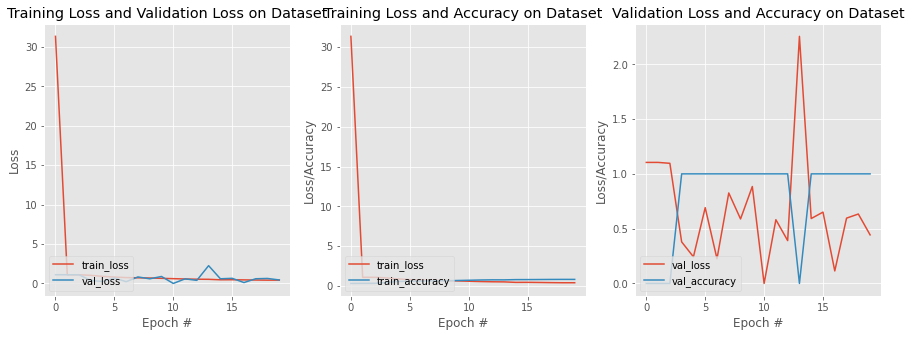

In [17]:
trained_model,train_generator,validation_generator = train_model(model)
label_dict= get_label_dict(train_generator)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
#model.save('/content/drive/MyDrive/Caba2012_colab/Fire_dt/models/resnet.h5')

In [18]:
%cd  '/content/drive/MyDrive/Caba2012_colab/Fire_dt/datasets/test_videos/'

video_path = '/content/drive/MyDrive/Caba2012_colab/Fire_dt/datasets/test_videos/test_ori.mp4'
predict ( trained_model, video_path, '/content/drive/MyDrive/Caba2012_colab/Fire_dt/datasets/test_videos/test_ori_pred_vgg16.mp4',  label_dict) 

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
pred_vec
[[0.03650313 0.49165422 0.47184265]]
1
0.49
최종txtNeutral[0.49]
pred_vec
[[0.03626623 0.4786118  0.48512203]]
2
0.49
최종txtSmoke[0.49]
pred_vec
[[0.03791149 0.48501253 0.47707602]]
1
0.49
최종txtNeutral[0.49]
pred_vec
[[0.03857467 0.48449174 0.4769337 ]]
1
0.48
최종txtNeutral[0.48]
pred_vec
[[0.03612809 0.39357567 0.5702963 ]]
2
0.57
최종txtSmoke[0.57]
pred_vec
[[0.0361509 0.3941678 0.5696813]]
2
0.57
최종txtSmoke[0.57]
pred_vec
[[0.03715355 0.50054616 0.46230033]]
1
0.5
최종txtNeutral[0.5]
pred_vec
[[0.0361242 0.5146752 0.4492006]]
1
0.51
최종txtNeutral[0.51]
pred_vec
[[0.03472547 0.5126061  0.4526685 ]]
1
0.51
최종txtNeutral[0.51]
pred_vec
[[0.03637661 0.52486646 0.4387569 ]]
1
0.52
최종txtNeutral[0.52]
pred_vec
[[0.03652954 0.5256707  0.43779975]]
1
0.53
최종txtNeutral[0.53]
pred_vec
[[0.03745877 0.5349626  0.42757863]]
1
0.53
최종txtNeutral[0.53]
pred_vec
[[0.0391442 0.5260505 0.4348052]]
1
0.53
최종txtNeutral[0.53]
pred_vec
[[0.04058035 0.5252214  0.43419823]]